In [14]:
import numpy as np
from vorothreshold.read_funcs import read_adjfile, read_voronoi_vide, voro_in_vide_voids, vide_voids_cat
from vorothreshold import voronoi_threshold
from vorothreshold.overlaps import compute_max_dist2, overlapping_fraction, select_overlaps
import pickle
from numba import jit
import matplotlib.pyplot as plt

In [54]:
#Vide info

dataPortion="all"
untrimmed = True
fullName = 'example_observation'
if untrimmed:
    prefix = "untrimmed_"
else:
    prefix = ""

vide_out = 'data/lightcone/examples/example_observation/sample_example_observation/'
adjfile = 'adj_example_observation.dat'

In [55]:
neighbor_ptr, neighbor_ids = read_adjfile(vide_out + adjfile)
print(neighbor_ptr.shape[0],neighbor_ids.shape[0])

ids_voro, VoroVol, VoroXYZ, RA, Dec, redshift = read_voronoi_vide(vide_out,fullName)
print(ids_voro.shape)
Ntot_part = ids_voro.shape[0]

barycenter,radius,redshift_vds,voidID,RA,DEC,coreID,core_dens,core_pos,RAcore,DECcore,redshift_core = vide_voids_cat(vide_out,fullName,
    values_out=['barycenter','radius','redshift','voidID','RA','DEC','core_ID','core_dens','core_pos','RAcore','DECcore','redshift_core'],as_dict=False)
print(barycenter.shape)

164648 1147080
(164647,)
(452, 3)


[0.00726143 0.01186588 0.01647034 0.02107479 0.02567925 0.03028371
 0.03488816 0.03949262 0.04409707 0.04870153 0.05330598 0.05791044
 0.06251489 0.06711935 0.07172381 0.07632826 0.08093272 0.08553717
 0.09014163 0.09474609 0.09935054 0.103955   0.10855946 0.11316391
 0.11776837 0.12237282 0.12697728 0.13158174 0.1361862  0.14079064
 0.1453951  0.14999956]
38
(452,) [133523  29625   1260   6224  27589   6196  12686   4264  71739  32899
 100978   4579   7652 137163 100346  25655  29247   3299   6235  15154
 136362 131161  26753  14686  56766   6219 159533  84204 142682  26330
 122245  61109  10989 118866  49942  57825  57164 128771 143315  73140
  36335   3789  85608  68526  62155   7181 105103 108196  99315    810
 146832   3754   3715 138817  33783  48106  90678   8014  67591  76018
  70704   3758 102139  94638  78356 157350 148586  48422 113072  57063
  52791 131291 142254 160399 134194  83404 139389  77348 141995  70944
  95075  29255  59633 161271 129559  31064   1640  79142 163398

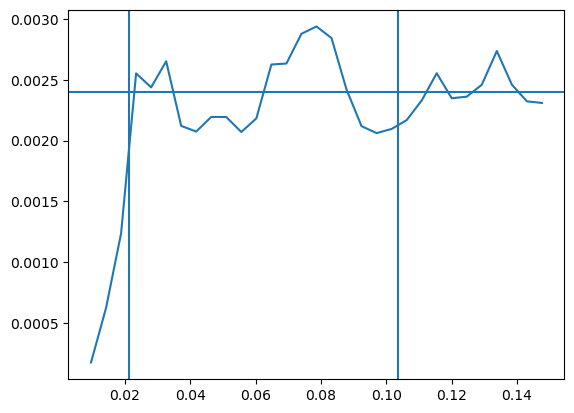

In [58]:
from cosmodata_functions.functions_for_data import ComovingDistanceOverh, ComovingDistanceOverh_explicit
import healpy as hp

mask_gal_file = 'data/lightcone/examples/example_observation/sample_example_observation/mask_map.fits'
mask = hp.read_map(mask_gal_file)
sky_frac = np.sum(mask)/mask.shape[0]
Omega_m = 0.32
w0=-1.
wa=0.
dist_z = ComovingDistanceOverh(Omega_m,w0,wa)
hist_z, z_bins = np.histogram(redshift,bins=31)

comov3 = dist_z.get_dist(z_bins)**3
shell_vol = 4*np.pi/3.*sky_frac*(comov3[1:] - comov3[:-1])
print(z_bins)
z_mean = 0.5 * (z_bins[1:] + z_bins[:-1])
plt.plot(z_mean,hist_z/shell_vol)
plt.axhline(np.mean((hist_z/shell_vol)[3:]))
plt.axvline(z_bins[3])

iv = np.argmax(radius)
print(iv)
ID_core = coreID[iv]
print(coreID.shape,coreID)
zDens = np.ones(Ntot_part) *np.mean((hist_z/shell_vol)[3:])
plt.axvline(redshift[ID_core])
print(zDens[0])

In [61]:
threshold = [0.3]
ID_core_arr = np.array([ID_core])
print(coreID.shape)
#IDthresholds = np.zeros(Ntot_part,dtype=np.int_)
selected_vsd, ID_voro_dict, Xcm, Vol_interp, Ncells_in_void, ell_eigenvalues, ell_eigenvectors = voronoi_threshold(
    threshold,coreID,neighbor_ptr,neighbor_ids,VoroXYZ,VoroVol,zDens,nthreads=1,verbose=True)
print(Xcm.shape,selected_vsd.shape)
print(selected_vsd)
print(np.argmax(Vol_interp))

(452,)

    voronoi_threshold started

    nthreads set to 1

    max_num_part set to 49394

    computation started
    done, 0 h 0 min 0.02600836753845215 sec. 

(215, 1, 3) (215,)
[  0   4   6   8   9  11  12  13  14  15  19  20  21  24  26  27  28  29
  30  31  32  35  36  38  39  42  43  46  47  49  50  52  53  54  57  62
  63  65  66  69  70  71  73  76  77  78  82  83  84  88  92  93  94  95
  96  97  98 101 102 104 105 107 109 111 114 116 117 120 123 125 126 128
 130 133 134 136 137 144 149 151 155 157 161 162 163 164 165 167 168 169
 170 172 173 176 178 180 181 182 183 187 190 192 194 196 198 202 204 206
 207 208 210 214 215 216 218 220 221 224 225 226 227 228 229 232 234 237
 238 240 243 246 247 248 255 257 259 260 261 263 266 269 270 272 273 274
 275 277 280 282 285 287 289 292 294 295 300 304 306 311 312 314 315 316
 318 320 323 325 326 331 332 336 339 345 346 347 351 353 362 365 367 368
 370 372 373 376 382 385 386 388 392 393 395 399 401 402 403 404 405 406
 410 412 415 4

In [53]:
iv_test = (np.arange(coreID.shape[0])[coreID == 29625])[0]
print(selected_vsd.shape[0])
iv = np.arange(selected_vsd.shape[0])[selected_vsd[:,0] == iv][0]
print('new iv:',iv,'iv_test',iv_test)
print(VoroVol[coreID[iv_test]])
print(ID_voro_dict[0].shape)
print(ID_voro_dict[iv][:int(Ncells_in_void[iv]+1)].shape)
print(np.max(Ncells_in_void))


289


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

(215, 1, 3)
(597,)


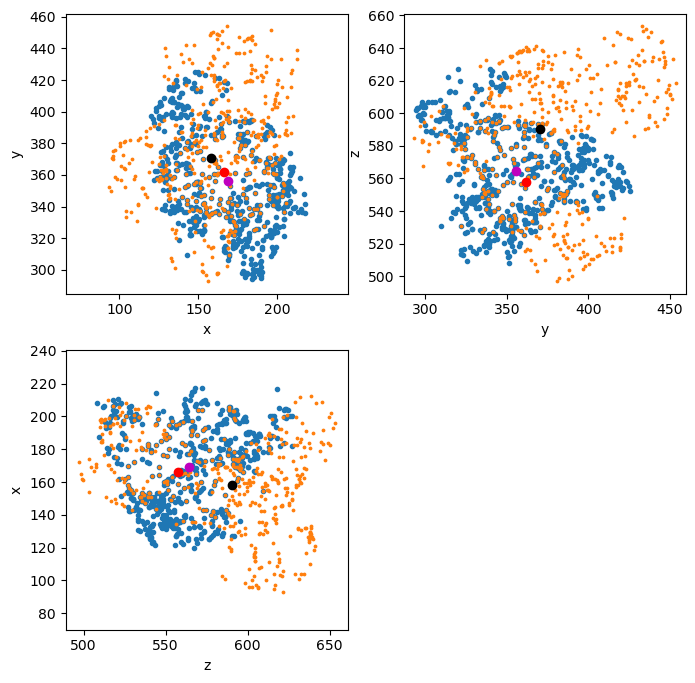

In [20]:

#Unique_IDS = zones2Parts[voidID[iv]].partIDs
print(Xcm.shape)
Xcm_interp = Xcm[iv,0,:]
IDthresholds = ID_voro_dict[iv][:int(Ncells_in_void[iv,0]+1)]
asd = voro_in_vide_voids(vide_out,fullName)
vide_id = selected_vsd[iv]
Unique_IDS = asd.get_voro_from_uniqueID(voidID[vide_id])
print(np.array(Unique_IDS).shape)
fig = plt.figure(figsize=(8,8))
ax = dict()
for i in range(3):
    ax[i] = plt.subplot2grid((2,2), (int(i/2),i%2), rowspan=1, colspan=1)

    ax[i].scatter(VoroXYZ[Unique_IDS,i%3],VoroXYZ[Unique_IDS,(i+1)%3],s=9)
    ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=3)
    ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3],c='k')
    ax[i].scatter(core_pos[vide_id,i%3],core_pos[vide_id,(i+1)%3],c='r',)
    ax[i].scatter(barycenter[vide_id,i%3],barycenter[vide_id,(i+1)%3],c='m')
    ax[i].axis('equal')
    ax[i].set_xlabel(['x','y','z'][i%3])
    ax[i].set_ylabel(['x','y','z'][(i+1)%3])

In [21]:
#max_dist_2 = compute_max_dist2(Ncells_in_void[:,0],Xcm[:,0,:],VoroXYZ,ID_voro_dict)
id_selected = np.arange(Xcm.shape[0])
id_selected = np.arange(Xcm.shape[0])[Ncells_in_void[:,0] > 10]
#print(Vol_interp[id_selected,0])
order_id_selected = (np.argsort(Vol_interp[id_selected,0]))[::-1]
print(id_selected.shape,Xcm.shape)
max_dist_2 = compute_max_dist2(Ncells_in_void[:,0],Xcm[:,0,:],VoroXYZ,id_selected,ID_voro_dict)


(100,) (215, 1, 3)


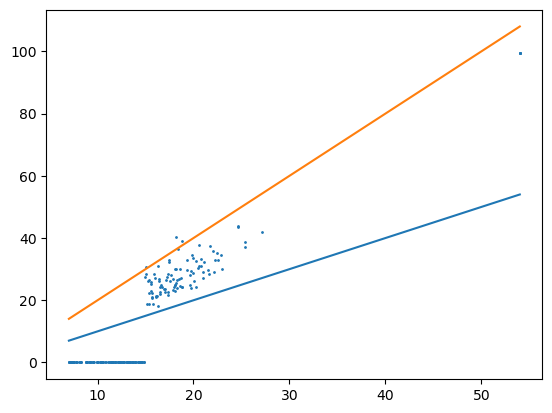

In [22]:
Rth = (Vol_interp[:,0] * 3 / (4.*np.pi)) ** (1/3)
plt.scatter(Rth,max_dist_2**0.5,s=1)
#plt.scatter(radius,max_dist_2**0.5)
plt.plot([np.min(Rth),np.max(Rth)],[np.min(Rth),np.max(Rth)])
plt.plot([np.min(Rth),np.max(Rth)],[2*np.min(Rth),2*np.max(Rth)])



In [23]:
ids_ovlp, Vol_ovlp, Vol_ovlp_frac, num_ovlps = overlapping_fraction(
    Xcm[:,0,:], Vol_interp[:,0], Ncells_in_void[:,0], VoroXYZ, VoroVol, ID_voro_dict,nthreads=1,id_selected=id_selected)


overlapping_fraction started.

    nthreads set to 1

    R_max computed. Max val = 99.47962675370397

    Lbox not passed, using xyz_vds as reference:
    min(xyz_vds) = 59.5640874057562 152.5123289442801 434.5368551001039
    max(xyz_vds) = 331.1237423314944 695.166523832096 755.7953061216401
    Lbox = 542.654194887816

    ngrid not passed. Set to optimal value: 5

    order_ids_tracers_selected_in_voxels started
    done, 0 h 0 min 0.6943750381469727 sec.

    computation started (periodic-boundaries condition off)
    done, 0 h 0 min 1.2954185009002686 sec. 



In [24]:
#id_ovlp = np.arange(num_ovlps.shape[0])[num_ovlps>0]
iv_test = np.arange(id_selected.shape[0])[id_selected == iv][0]
print(np.max(ids_ovlp),iv_test in id_selected)
print(iv_test,id_selected[np.argmax(num_ovlps)],np.max(num_ovlps),np.argmax(num_ovlps))
print(Xcm[iv,0,:],Xcm[np.argmax(num_ovlps),0,:])
print(Xcm[iv,0,:],Xcm[np.argmax(num_ovlps),0,:])
print(ids_ovlp[np.argmax(num_ovlps),:num_ovlps[np.argmax(num_ovlps)]])
print(ids_ovlp[iv,:num_ovlps[iv]])
print(ids_ovlp[iv_test,:num_ovlps[iv_test]])

print(num_ovlps.shape,ids_ovlp.shape)
print(iv,num_ovlps[iv],num_ovlps[iv_test],num_ovlps[np.argmax(num_ovlps)])
print(iv,num_ovlps[iv],ids_ovlp[iv,:num_ovlps[iv]],Vol_ovlp[iv,:num_ovlps[iv]],Vol_ovlp_frac[iv,:num_ovlps[iv]])

213 False
10 23 8 10
[158.01646861 370.45973348 590.49169568] [ 34.70551858 398.68691253 453.13519392]
[158.01646861 370.45973348 590.49169568] [ 34.70551858 398.68691253 453.13519392]
[124  79  87 113 185 195 197  72]
[]
[124  79  87 113 185 195 197  72]
(100,) (100, 100)
23 0 8 8
23 0 [] [] []


#id_ovlp = np.arange(num_ovlps.shape[0])[num_ovlps>0]
print(np.max(num_ovlps))
print(num_ovlps[iv],ids_ovlp[iv,:num_ovlps[iv]],Vol_ovlp[iv,:num_ovlps[iv]],Vol_ovlp_frac[iv,:num_ovlps[iv]])

(215, 1, 3)


(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

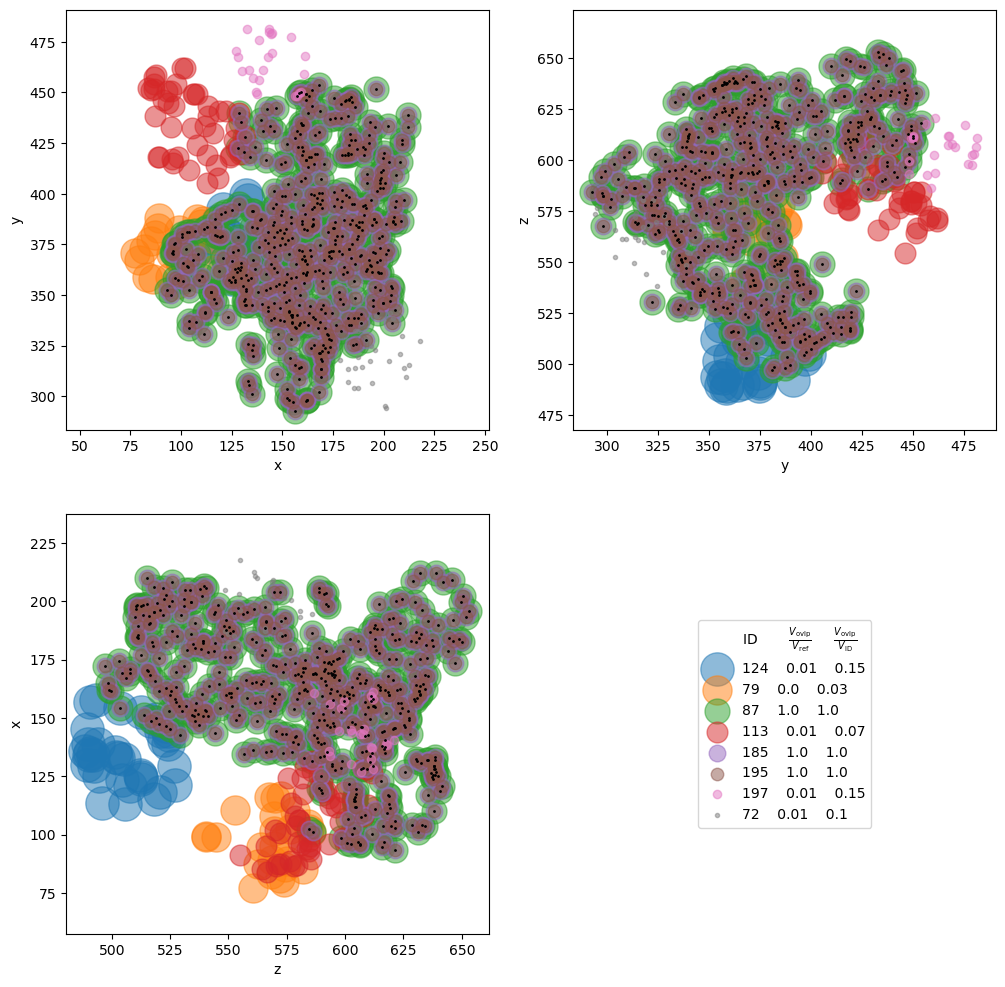

In [25]:
print(Xcm.shape)
asd = voro_in_vide_voids(vide_out,fullName)
Ncells_loop = int(Ncells_in_void[iv,0]) + int(round(Ncells_in_void[iv,0]%1))
Vol_tot_ref = np.sum(VoroVol[ID_voro_dict[iv][:Ncells_loop]])
#print(Vol_tot_ref,Vol_interp[iv,0],Ncells_loop,VoroVol.shape,ID_voro_dict[iv].shape)
fig = plt.figure(figsize=(12,12))
ax = dict()
for i in range(4):
    ax[i] = plt.subplot2grid((2,2), (int(i/2),i%2), rowspan=1, colspan=1)
progr = 0
for id in ids_ovlp[iv_test,:num_ovlps[iv_test]]:
    Xcm_interp = Xcm[id,0,:]
    IDthresholds = ID_voro_dict[id][:int(Ncells_in_void[id,0]+1)]

    for i in range(3):
        ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=(3*(num_ovlps[iv_test] - progr))**2,alpha=0.5)
            #ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3])
        #ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
        #ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
        ax[i].axis('equal')
        ax[i].set_xlabel(['x','y','z'][i%3])
        ax[i].set_ylabel(['x','y','z'][(i+1)%3])
    Ncells_loop = int(Ncells_in_void[id,0]) + int(round(Ncells_in_void[id,0]%1))
    Vol_tot_id = np.sum(VoroVol[ID_voro_dict[id][:Ncells_loop]])
    #print(Vol_ovlp[iv,progr],Vol_ovlp[iv,:8],Vol_tot_id,Vol_tot_id)
    ax[3].scatter([np.nan],[np.nan],s=(3*(num_ovlps[iv_test] - progr))**2,alpha=0.5,label=str(id)+'    '+str(round(Vol_ovlp[iv_test,progr]/Vol_tot_ref,2))+
                  '    '+str(round(Vol_ovlp[iv_test,progr]/Vol_tot_id,2)))
    progr +=1
Xcm_interp = Xcm[iv,0,:]
IDthresholds = ID_voro_dict[iv][:int(Ncells_in_void[iv,0]+1)]
for i in range(3):
    ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=1,c='k')
        #ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3])
    #ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
    #ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
    ax[i].axis('equal')
    ax[i].set_xlabel(['x','y','z'][i%3])
    ax[i].set_ylabel(['x','y','z'][(i+1)%3])
ax[3].legend(loc='center',title='       ID       $\\frac{V_{\\rm ovlp}}{V_{\\rm ref}}$     $\\frac{V_{\\rm ovlp}}{V_{\\rm ID}}$')
ax[3].axis('off')

In [29]:
#id_selected = np.arange(Vol_interp.shape[0])[Vol_interp[:,0] > 0]

print(num_ovlps.shape,id_selected.shape,ids_ovlp.shape,Vol_ovlp_frac.shape)

import time
t0 = time.time()
id_out = select_overlaps(0.12,id_selected,order_id_selected, ids_ovlp, Vol_ovlp_frac, num_ovlps)  
#id_out = select_overlaps_old(0.1,order_id_selected, ids_ovlp, Vol_ovlp_frac, num_ovlps)
print(time.time()-t0,id_out.shape)
#print(id_out.shape, [(ii, ii in id_out) for ii in ids_ovlp[iv,:num_ovlps[iv]]])

(100,) (100,) (100, 100) (100, 100)
0.00010442733764648438 (72,)


(72,) (100,) (215, 1)
23 659773.6515754757 10446.515679421116
[  0   1   3   5  13  16  18  19  20  23  24  26  35  37  40  42  44  45
  46  47  48  49  50  54  57  59  60  63  65  66  68  69  72  74  76  79
  80  81  84  86  88  92  93  94  96 105 108 111 113 122 126 127 128 129
 132 140 145 148 151 153 159 162 169 176 177 186 189 192 199 200 212 213]


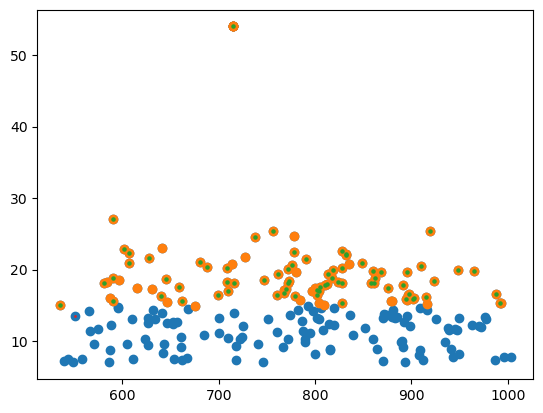

In [47]:
print(id_out.shape,id_selected.shape,Vol_interp.shape)
comov_dist = np.sum(Xcm[:,0,:]**2,axis=1)**0.5


plt.scatter(comov_dist[:],(Vol_interp[:,0]* 3. / (4. * np.pi)) ** (1./3.))
plt.scatter(comov_dist[id_selected],(Vol_interp[id_selected,0]* 3. / (4. * np.pi)) ** (1./3.))
plt.scatter(comov_dist[id_selected[id_out]],(Vol_interp[id_selected[id_out],0]* 3. / (4. * np.pi)) ** (1./3.),s=5)


print(np.argmax(Vol_interp[:,0]),np.max(Vol_interp[:,0]),Vol_interp[25,0])
plt.scatter(comov_dist[25],(Vol_interp[25,0]* 3. / (4. * np.pi)) ** (1./3.),s=1)
print(np.sort(id_selected[id_out]))

(215, 1, 3)


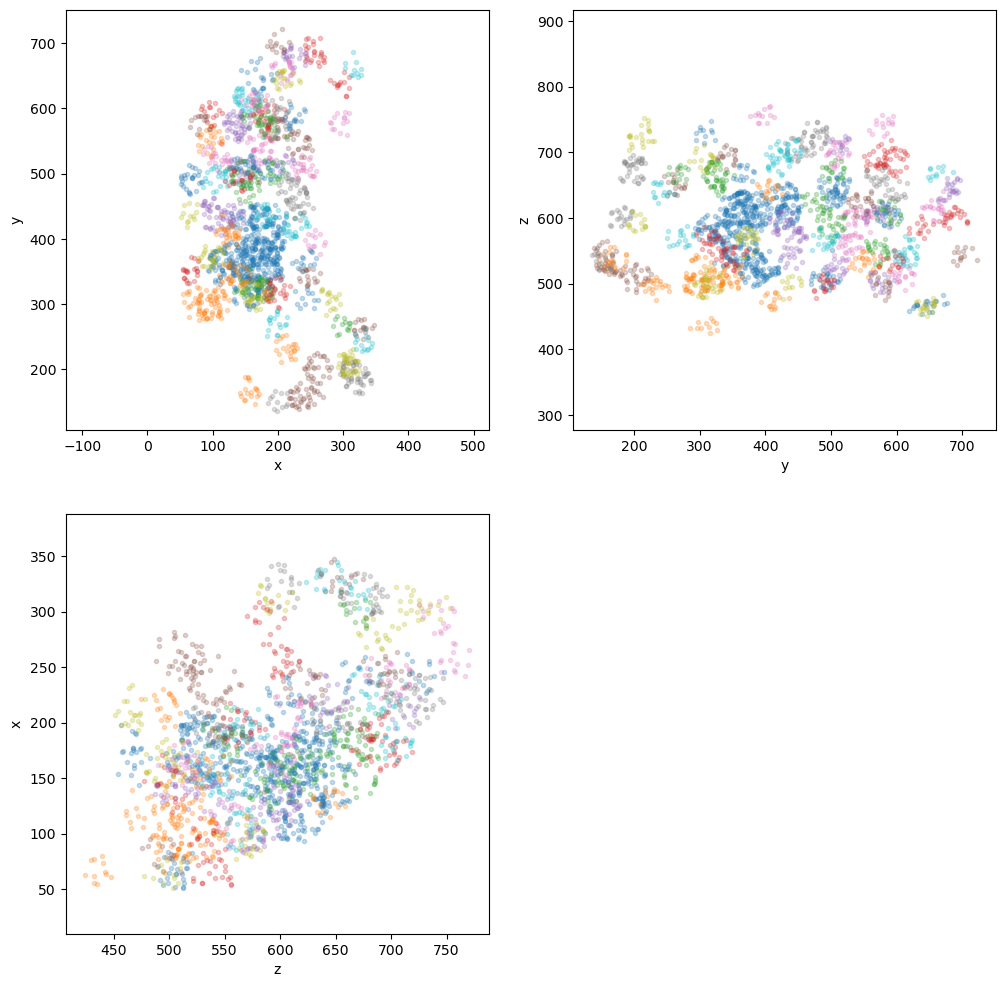

In [31]:
print(Xcm.shape)
asd = voro_in_vide_voids(vide_out,fullName)
Ncells_loop = int(Ncells_in_void[iv,0]) + int(round(Ncells_in_void[iv,0]%1))
Vol_tot_ref = np.sum(VoroVol[ID_voro_dict[iv][:Ncells_loop]])
#print(Vol_tot_ref,Vol_interp[iv,0],Ncells_loop,VoroVol.shape,ID_voro_dict[iv].shape)
fig = plt.figure(figsize=(12,12))
ax = dict()
for i in range(3):
    ax[i] = plt.subplot2grid((2,2), (int(i/2),i%2), rowspan=1, colspan=1)
progr = 0
for id in id_selected[id_out]:
    Xcm_interp = Xcm[id,0,:]
    IDthresholds = ID_voro_dict[id][:int(Ncells_in_void[id,0]+1)]

    for i in range(3):
        ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=9,alpha=0.25)
            #ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3])
        #ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
        #ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
    progr +=1
Xcm_interp = Xcm[iv,0,:]
IDthresholds = ID_voro_dict[iv][:int(Ncells_in_void[iv,0]+1)]
for i in range(3):
    ax[i].axis('equal')
    ax[i].set_xlabel(['x','y','z'][i%3])
    ax[i].set_ylabel(['x','y','z'][(i+1)%3])
#ax[3].legend(loc='center',title='       ID       $\\frac{V_{\\rm ovlp}}{V_{\\rm ref}}$     $\\frac{V_{\\rm ovlp}}{V_{\\rm ID}}$')
#ax[3].axis('off')